# Audio Recognition

In [1]:
#import pyaudio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import os
import numpy as np
import pandas as pd
import random
from skimage.measure import block_reduce
# from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

#To find the duration of wave file in seconds
import wave
import contextlib
import librosa
import soundfile as sf

#Keras imports
import keras
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
import tensorflow as tf

import time
import datetime

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
def save_model_to_disk(model):
    """
    Converts the model to a json and saves as an h5 file
    """
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to disk")

plt.rcParams['figure.dpi'] = 80
def graph_spectrogram(wav_file, nfft=512, noverlap=511):
    """
    Converts the wav file to a B/W spectrogram for the NN to interpret
    """
    rate, data = wavfile.read(wav_file)
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, cmap="gray", noverlap=noverlap, NFFT=nfft)
#     pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, mode="magnitude", cmap="gray", noverlap=noverlap, NFFT=nfft)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
#     plt.rcParams['figure.figsize'] = [3,2]

    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()

    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    # image is greyscale so all channels are the same, just need one channel
    imarray = np.reshape(mplimage, (int(height), int(width), 3))[:,:,1]
    plt.close(fig)
    # normalize AKA min/max scale the array
    imarray = (imarray - imarray.min())/(imarray.max() - imarray.min())
    return imarray

def load_waves(fpath):
    fpath = 'train/audio/' + fpath
    normgram = graph_spectrogram(fpath)
    redgram = block_reduce(normgram, block_size = (3,3), func = np.mean)
    # looks like block_reduce here is gaussian blur w/out padding
    return redgram

## Creating a Directory for the Files

In [4]:
folder_names = [f for f in os.listdir('train/audio') if not 'background' in f]
folder_names.sort()

file = open("train/testing_list.txt", "r")
testing_list = file.read().split('\n')
file.close()
file = open("train/validation_list.txt", "r")
validation_list = file.read().split('\n')

master_file_list = []
master_target_list = []
train_val_test_list = []
for phrase in folder_names:
    file_list = [phrase + '/' + f for f in os.listdir('train/audio/' + phrase) if '.wav' in f]
    for file in file_list:
        if file in testing_list:
            train_val_test_list.append('test')
        elif file in validation_list:
            train_val_test_list.append('val')
        else:
            train_val_test_list.append('train')
        master_target_list.append(phrase)
        master_file_list.append(file)
data = np.transpose(np.array([master_file_list, master_target_list, train_val_test_list]))
master_df = pd.DataFrame(data = data, columns=['filename','target','train_val_test'])
master_df.head()

,filename,target,train_val_test
0,bed/00176480_nohash_0.wav,bed,train
1,bed/004ae714_nohash_0.wav,bed,train
2,bed/004ae714_nohash_1.wav,bed,train
3,bed/00f0204f_nohash_0.wav,bed,train
4,bed/00f0204f_nohash_1.wav,bed,train


## Creating the Keras Model

In [5]:
def new_keras(input_shape):
    # input_shape = (imheight, imwidth, 1)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(BatchNormalization(axis=3))
    # model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(BatchNormalization(axis=3))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

#     opt = keras.optimizers.Adam()
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

def plot_results(history):
    # changes figsize back to default size
    plt.rcParams['figure.figsize'] = [6.4, 4.8]
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.ylim(0,1)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Loading the Files and Training the Model

In [6]:
def train_val_load(X, y, num_classes, train_or_val):
    if train_or_val == 'train':
        print('loading training set')
    else:
        print('loading validation set')
        
    sound_clips = []
    for ind, fpath in enumerate(X):
        # update code to `try` loading pickles
        # or preprocess sound clips and save as pickles
        redgram = load_waves(fpath)
#         if redgram.shape[0] > 150:
#             print('\tbad redgram shape')
#             # if still experiencing sporadic accuracy
#             # see if it's on the 'bad normgram shape' batches
#             # might be an indexing error
#             y = np.delete(y, ind)
#             continue
        if redgram.shape[0] != 14:
            print('\tbad redgram shape')
            # if experiencing sporadic accuracy
            # see if it's on the 'bad normgram shape' batches
            # might be an indexing error
            y = np.delete(y, ind)
            continue
        sound_clips.append(redgram)
    sound_clips = np.asarray(sound_clips, dtype=np.float32)
#     sound_clips = np.array(sound_clips, dtype=np.float32)
    print(f'\tx shape (before reshape):{sound_clips.shape}')
    sound_clips = sound_clips.reshape( # maybe this is the error? looks like one of the sound clips had a super choppy spectrogram
                                sound_clips.shape[0],
                                sound_clips.shape[1], 
                                sound_clips.shape[2],1)
    print(f'\tx shape (after reshape):{sound_clips.shape}')
    
    for y_ind in range(len(y)):
        y[y_ind] = mapping[y[y_ind]]
    y = keras.utils.to_categorical(y, num_classes) # this might be the part that's fubar, try keras ohe. should still work decent for the number of samples tho?
    print(f'\ty shape:{y.shape}')
    
    # to see if the spectrogram looks decent
    sns.heatmap(sound_clips[0][:,:,0])
    plt.show()
    
    return sound_clips, y

Label mapping:
{'marvin': 0, 'bed': 1, 'sheila': 2, 'down': 3, 'nine': 4, 'one': 5, 'bird': 6, 'three': 7, 'cat': 8, 'dog': 9, 'tree': 10, 'up': 11, 'no': 12, 'happy': 13, 'six': 14, 'yes': 15, 'house': 16, 'go': 17, 'wow': 18, 'eight': 19, 'right': 20, 'four': 21, 'zero': 22, 'stop': 23, 'on': 24, 'off': 25, 'five': 26, 'two': 27, 'left': 28, 'seven': 29}
working on batch: 1/150
loading training set


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


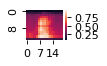

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


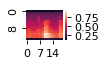

Loading an existing model
Epoch 1/50
19/19 [==============================] - 1s 19ms/step - loss: 2.1273 - accuracy: 0.4083 - val_loss: 2.3186 - val_accuracy: 0.2887
Epoch 2/50
19/19 [==============================] - 0s 9ms/step - loss: 1.9736 - accuracy: 0.3391 - val_loss: 2.3409 - val_accuracy: 0.3505
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 2.1242 - accuracy: 0.3806 - val_loss: 2.3372 - val_accuracy: 0.3196
Epoch 4/50
19/19 [==============================] - 0s 10ms/step - loss: 1.9134 - accuracy: 0.4118 - val_loss: 2.2239 - val_accuracy: 0.3608
Epoch 5/50
19/19 [==============================] - 0s 10ms/step - loss: 1.8582 - accuracy: 0.4118 - val_loss: 2.2976 - val_accuracy: 0.3402
Epoch 6/50
19/19 [==============================] - 0s 11ms/step - loss: 1.7789 - accuracy: 0.4360 - val_loss: 2.2645 - val_accuracy: 0.3505
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 1.7379 - accuracy: 0.4637 - val_loss: 2.3232 - val_accurac

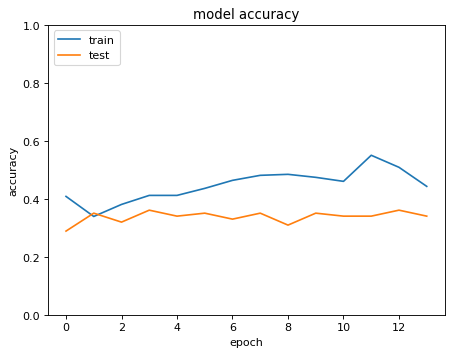

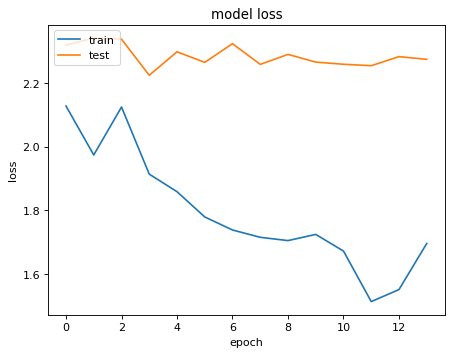

INFO:tensorflow:Assets written to: ./MyModel_tf\assets
working on batch: 2/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


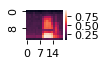

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


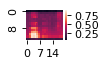

Loading an existing model
Epoch 1/50
18/18 [==============================] - 1s 16ms/step - loss: 2.3462 - accuracy: 0.2951 - val_loss: 2.2947 - val_accuracy: 0.3093
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 2.2833 - accuracy: 0.2917 - val_loss: 2.2935 - val_accuracy: 0.3196
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3775 - accuracy: 0.2847 - val_loss: 2.2916 - val_accuracy: 0.3196
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 2.2941 - accuracy: 0.2986 - val_loss: 2.2905 - val_accuracy: 0.3196
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3728 - accuracy: 0.2847 - val_loss: 2.2898 - val_accuracy: 0.3196
Epoch 6/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3443 - accuracy: 0.3125 - val_loss: 2.2890 - val_accuracy: 0.3196
Epoch 7/50
18/18 [==============================] - 0s 8ms/step - loss: 2.2922 - accuracy: 0.3264 - val_loss: 2.2883 - val_accuracy: 

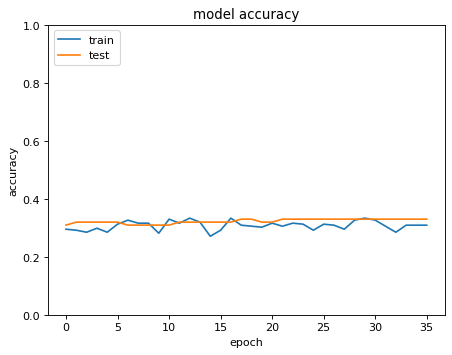

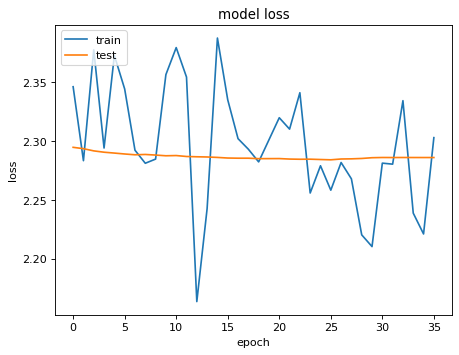

INFO:tensorflow:Assets written to: ./MyModel_tf\assets
working on batch: 3/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


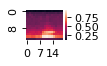

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


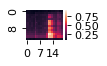

Loading an existing model
Epoch 1/50
18/18 [==============================] - 1s 14ms/step - loss: 2.3601 - accuracy: 0.3021 - val_loss: 2.2853 - val_accuracy: 0.3196
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3243 - accuracy: 0.3160 - val_loss: 2.2853 - val_accuracy: 0.3196
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 2.3667 - accuracy: 0.3299 - val_loss: 2.2853 - val_accuracy: 0.3196
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 2.2397 - accuracy: 0.3368 - val_loss: 2.2853 - val_accuracy: 0.3196
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3241 - accuracy: 0.3264 - val_loss: 2.2853 - val_accuracy: 0.3196
Epoch 6/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3813 - accuracy: 0.3125 - val_loss: 2.2853 - val_accuracy: 0.3196

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 7/50
18/18 [==============================] - 

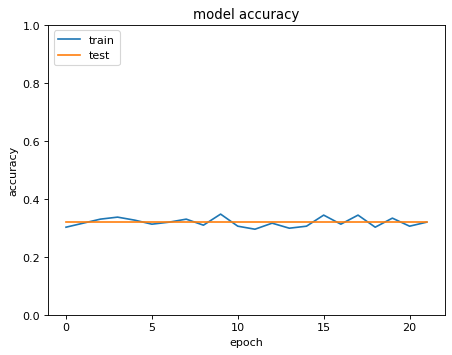

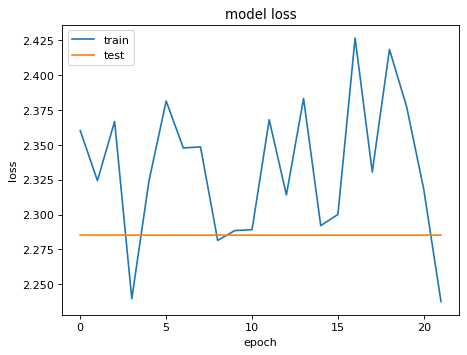

INFO:tensorflow:Assets written to: ./MyModel_tf\assets
working on batch: 4/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


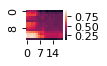

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


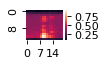

Loading an existing model
Epoch 1/50
18/18 [==============================] - 1s 15ms/step - loss: 2.2725 - accuracy: 0.3264 - val_loss: 2.1465 - val_accuracy: 0.3402
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 2.2693 - accuracy: 0.3333 - val_loss: 2.1465 - val_accuracy: 0.3402
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3199 - accuracy: 0.2812 - val_loss: 2.1465 - val_accuracy: 0.3402
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 2.2795 - accuracy: 0.3160 - val_loss: 2.1465 - val_accuracy: 0.3402
Epoch 5/50
18/18 [==============================] - 0s 9ms/step - loss: 2.2659 - accuracy: 0.2882 - val_loss: 2.1465 - val_accuracy: 0.3402
Epoch 6/50
18/18 [==============================] - 0s 8ms/step - loss: 2.3049 - accuracy: 0.3299 - val_loss: 2.1465 - val_accuracy: 0.3402

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 7/50
18/18 [==============================] - 

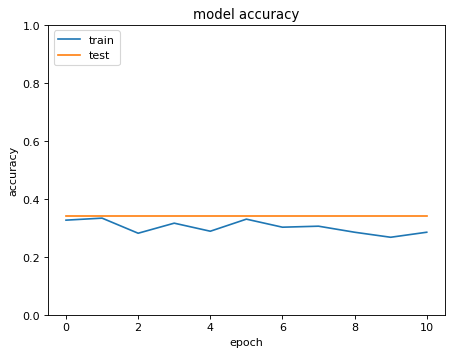

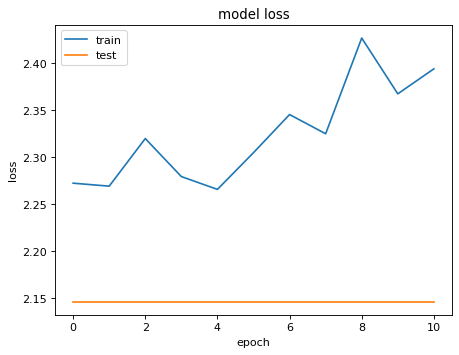

INFO:tensorflow:Assets written to: ./MyModel_tf\assets
working on batch: 5/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


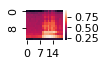

loading validation set


In [ ]:
num_classes = len(master_df['target'].unique().tolist())
# SKF is just being used to batch the data into memory, not do any sort of k-fold training process

X_master = master_df['filename'][[(val in ['train','val']) for val in master_df['train_val_test']]]
y_master = master_df['target'][[(val in ['train','val']) for val in master_df['train_val_test']]]
X_master, y_master = np.array(X_master), np.array(y_master)

# from https://www.educative.io/edpresso/how-to-perform-one-hot-encoding-using-keras
# also has link to OHE using sklearn
y_master_set = list(set(y_master))
mapping = {}
for y in range(len(y_master_set)):
    mapping[y_master_set[y]] = y
print(f'Label mapping:\n{mapping}')

batch_count = 1 # using a counter since enumerate doesn't work on skf.split
total_splits = 150
skf = StratifiedKFold(n_splits=total_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_master, y_master):
    print(f'working on batch: {batch_count}/{total_splits}')
    rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=42)
    X, y = X_master[test_index], y_master[test_index]
    for train_index2, test_index2 in rs.split(X):
        X_train, X_val = X[train_index2], X[test_index2]
        y_train, y_val = y[train_index2], y[test_index2]
        # Split is done, X=filename, y=target
        X_train, y_train = train_val_load(X_train, y_train, num_classes, train_or_val = 'train')
        X_val, y_val = train_val_load(X_val, y_val, num_classes, train_or_val = 'val')
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                                                    monitor='val_loss',
                                                    factor=0.1,
                                                    patience=5,
#                                                     cooldown=3,
                                                    verbose=1)
        early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    patience=10,
                                                    verbose=1,
                                                    restore_best_weights=True)
        try:
            print("Loading an existing model")
            loaded_model = tf.keras.models.load_model('./MyModel_tf')
            history = loaded_model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=[reduce_lr, early_stopping], verbose=1, validation_data=(X_val, y_val))
            plot_results(history)
            loaded_model.save('./MyModel_tf',save_format='tf')
        except:
            print("Starting with a fresh model")
            model = new_keras(input_shape=(
                                    X_train.shape[1], 
                                    X_train.shape[2],1))
            history = model.fit(X_train, y_train, batch_size=16, epochs=30, callbacks=[reduce_lr, early_stopping], verbose=1, validation_data=(X_val, y_val))
            plot_results(history)
            model.save('./MyModel_tf',save_format='tf')
            model=[]
        X_train, y_train, X_val, y_val = [],[],[],[]
    batch_count += 1